In [1]:
from neo4j import GraphDatabase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")
driver = GraphDatabase.driver(URI, auth=AUTH)

In [3]:
def create_trade_nodes(tx, trade_data):
    query = """
    UNWIND $trades AS trade
    CREATE (t:Trade {
        id: trade.id, 
        symbol: trade.symbol, 
        price: trade.price, 
        volume: trade.volume, 
        timestamp: trade.timestamp
    })
    """
    tx.run(query, trades=trade_data)

In [4]:
def create_trade_relationships(tx):
    query = """
    MATCH (t1:Trade), (t2:Trade)
    WHERE t1.symbol = t2.symbol AND t1.timestamp < t2.timestamp
    WITH t1, t2 ORDER BY t1.timestamp
    MERGE (t1)-[:NEXT_TRADE]->(t2)
    """
    tx.run(query)

In [5]:
def fetch_trade_data():
    # Example Data (Replace with real API or CSV loading logic)
    data = {
        "id": [1, 2, 3, 4, 5],
        "symbol": ["AAPL", "AAPL", "AAPL", "AAPL", "AAPL"],
        "price": [150, 152, 151, 155, 160],
        "volume": [1000, 1200, 1100, 1400, 1300],
        "timestamp": [1, 2, 3, 5, 6]  # Notice a gap between 3 and 5
    }
    return pd.DataFrame(data)

In [6]:
def detect_gaps(tx):
    query = """
    MATCH (t1:Trade)-[:NEXT_TRADE]->(t2:Trade)
    WHERE t2.timestamp - t1.timestamp > 1
    RETURN t1.id AS start_id, t2.id AS end_id, t1.timestamp AS start_time, t2.timestamp AS end_time
    """
    return list(tx.run(query))

In [7]:
def visualize_gaps(gaps):
    df = pd.DataFrame(gaps, columns=["start_id", "end_id", "start_time", "end_time"])
    fig = px.scatter(df, x="start_time", y="end_time", title="Trade Gaps", labels={"start_time": "Start Timestamp", "end_time": "End Timestamp"})
    fig.show()

In [10]:
def visualize_trade_graph(trade_data):
    plt.figure(figsize=(10, 6))
    plt.plot(trade_data['timestamp'], trade_data['price'], marker='o', linestyle='-')
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.title("Stock Trade Price Over Time")
    plt.grid()
    plt.show()

In [12]:
def compare_with_expected_patterns(trade_data):
    expected_price_range = (min(trade_data['price']) - 2, max(trade_data['price']) + 2)
    trade_data['price_deviation'] = ~trade_data['price'].between(*expected_price_range)
    anomalies = trade_data[trade_data['price_deviation']]
    print("Detected anomalies:")
    print(anomalies)
    return anomalies

C:\Users\HP\AppData\Local\Temp\ipykernel_45164\856784825.py:5: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



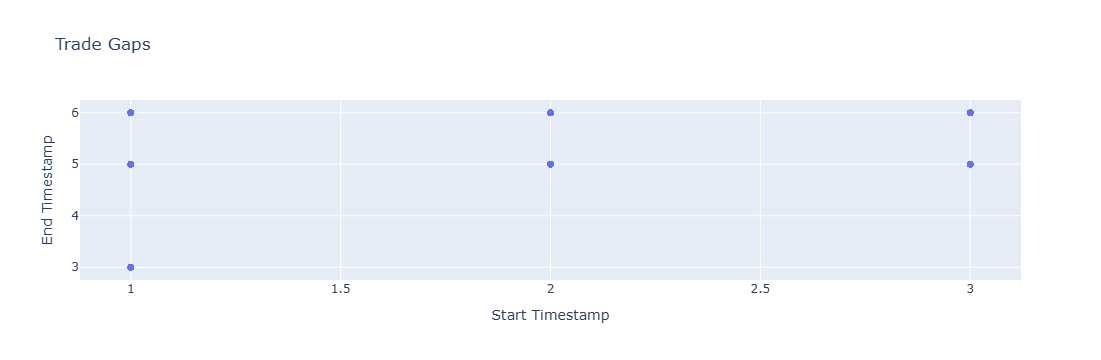

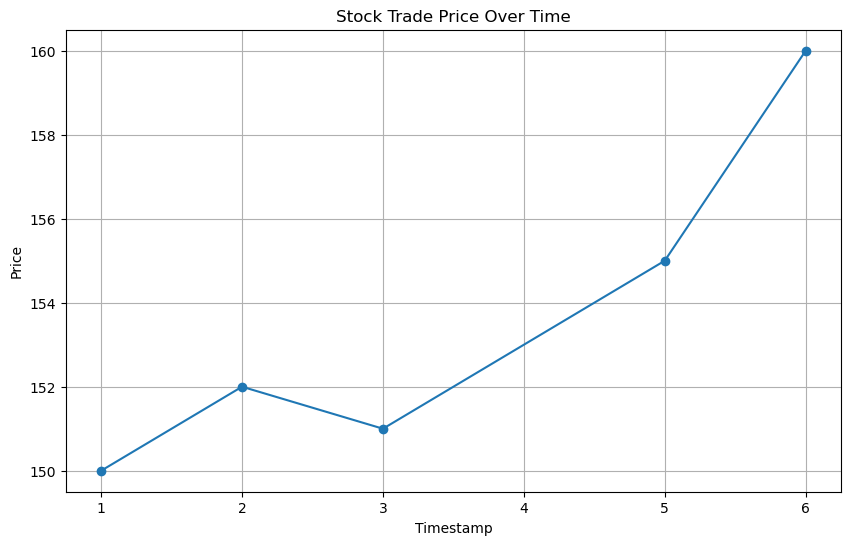

Detected anomalies:
Empty DataFrame
Columns: [id, symbol, price, volume, timestamp, price_deviation]
Index: []


In [18]:
def main():
    trade_data = fetch_trade_data()
    trade_data_dict = trade_data.to_dict(orient='records')
    
    with driver.session() as session:
        session.execute_write(create_trade_nodes, trade_data_dict)
        session.execute_write(create_trade_relationships)
        gaps = session.execute_read(detect_gaps)

    visualize_gaps(gaps)
    visualize_trade_graph(trade_data)
    compare_with_expected_patterns(trade_data)

# Ensure driver is closed after main() execution
if __name__ == "__main__":
    main()
    #driver.close()  # Closing driver after all processing is done
